<a href="https://colab.research.google.com/github/clustering-jun/KMU-Data_Science/blob/main/L11_Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Naive Bayes Practice**

## **SMS 스팸 데이터**
- 문자메시지 데이터
- spam과 ham으로 분류

- https://archive.ics.uci.edu/dataset/228/sms+spam+collection

In [1]:
!wget https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip
!unzip sms+spam+collection.zip

--2025-08-09 13:19:29--  https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘sms+spam+collection.zip’

sms+spam+collection     [             <=>    ] 198.65K  50.0KB/s    in 4.0s    

2025-08-09 13:19:34 (50.0 KB/s) - ‘sms+spam+collection.zip’ saved [203415]

Archive:  sms+spam+collection.zip
  inflating: SMSSpamCollection       
  inflating: readme                  


## **데이터 전처리**
- SMS을 Bag-of-Words 형태로 변환
- train, test 데이터 분리

In [2]:
import re
import random

data = []

with open('SMSSpamCollection', 'r') as f:
    for line in f:
        label, txt = line.split('\t')
        bow = set(re.findall('[a-z0-9_]+', txt.lower()))
        data.append( (label, bow) )

random.shuffle(data)

n_train = int(len(data) * 0.8)

train = data[:n_train]
test = data[n_train:]

## **데이터 나누기 / 사전확률 구하기**
- Train 데이터에서 Spam와 Ham 구분하기
- 스팸 메시지와 일반 메시지의 개수를 세어 사전확률 구하기(로그적용)

In [3]:
import math

alpha = 1e-4

n_ham = sum(1 for label, bow in train if label == 'ham')
n_spam = sum(1 for label, bow in train if label == 'spam')

prior_ham = math.log((n_ham + alpha) / (n_train + 2*alpha))
prior_spam = math.log((n_spam + alpha) / (n_train + 2*alpha))

## **Word Count**
- 각 단어별로 몇 개의 스팸 메시지와 일반 메시지에 등장했는지 세기
- Counter 써도 됨.

```
spam_words = Counter(word for bow in train_spam for word in bow)
ham_words = Counter(word for bow in train_ham for word in bow)

```



In [4]:
# 단어 w의 spam일 가능도 = P(w|spam) = log( (w를 포함하는 스팸수 + a) / (스팸 수 + a) )

from collections import defaultdict

words_ham = defaultdict(lambda : 0)
words_spam = defaultdict(lambda : 0)

for label, bow in train:
    for word in bow:
        if label == 'spam':
            words_spam[word] += 1
        else:
            words_ham[word] += 1

like_ham = defaultdict(lambda : math.log(alpha / (n_ham + alpha)))
like_spam = defaultdict(lambda : math.log(alpha / (n_spam + alpha)))

for word, cnt in words_ham.items():
    like_ham[word] = math.log( (cnt + alpha) / (n_ham + alpha) )

for word, cnt in words_spam.items():
    like_spam[word] = math.log( (cnt + alpha) / (n_spam + alpha) )

In [5]:
sorted(like_spam.items(), key = lambda x: x[1], reverse=True)[30:45]

[('reply', -2.1282304473468723),
 ('our', -2.142619164095068),
 ('prize', -2.172033006039474),
 ('just', -2.233590804274779),
 ('only', -2.249591120019623),
 ('are', -2.249591120019623),
 ('send', -2.282380889079261),
 ('s', -2.2991879791471024),
 ('no', -2.3162823832837756),
 ('won', -2.3162823832837756),
 ('t', -2.3336740957476634),
 ('150p', -2.3336740957476634),
 ('in', -2.3693921145540036),
 ('uk', -2.406433317623845),
 ('new', -2.406433317623845)]

## **Predict()**
- naive bayes 방법에 따라 spam/ham 점수를 구하여 비교
- 라플라스 스무딩 적용
- 로그 합산

In [6]:
def predict(bow):
    ham_score = prior_ham
    spam_score = prior_spam

    for word in bow:
        ham_score += like_ham[word]
        spam_score += like_spam[word]

    if ham_score > spam_score:
        return 'ham'
    else:
        return 'spam'

## **Test**
- Precision, Recall, F1 score, Accuracy

In [7]:
tp, tn, fp, fn  = 0, 0, 0, 0

for label, bow in test:
    result = predict(bow)
    if result == 'spam' and label == 'spam':
        tp += 1
    elif result == 'spam' and label == 'ham':
        fp += 1
    elif result == 'ham' and label == 'spam':
        fn += 1
    elif result == 'ham' and label == 'ham':
        tn += 1

print(tp, tn, fp, fn)

154 933 23 5


In [8]:
accuracy = (tn + tp) / (tp + tn + fp + fn)
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = 2 * recall * precision / (recall + precision)

print('accuracy:', accuracy)
print('recall:', recall)
print('precision:', precision)
print('f1 score:', f1)

accuracy: 0.9748878923766816
recall: 0.9685534591194969
precision: 0.8700564971751412
f1 score: 0.9166666666666666


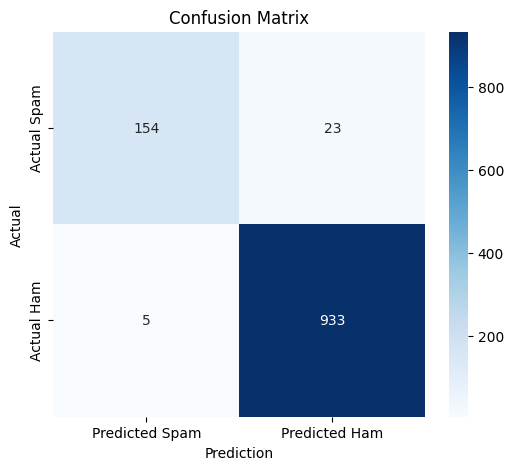

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

conf_matrix = np.array([[tp, fp],
                        [fn, tn]])

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Spam', 'Predicted Ham'],
            yticklabels=['Actual Spam', 'Actual Ham'])
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()